In [36]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from numpy.fft import ifftshift,fftshift,fft2,ifft2
from os.path import join,isfile
import pySPM
from math import pi
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

In [71]:

def Rotate_v(theta, v):
    theta = theta/180*pi
    rotation_matrix = np.zeros((2, 2)) 
    rotation_matrix[0, 0] = np.cos(theta) 
    rotation_matrix[1, 1] = np.cos(theta) 
    rotation_matrix[0, 1] = -np.sin(theta) 
    rotation_matrix[1, 0] = np.sin(theta) 
    return np.dot(rotation_matrix,v)

def plot_topo(SXMfile,fig,ax,title="SiC",scalecolor="white",scalesize=0.3): 
    Z_image=SXMfile.get_channel('Z')
    Z_image.correct_median_diff()
    Z_image.correct_lines() 
    x_n,y_n=Z_image.size["real"]["x"]*1e9,Z_image.size["real"]["y"]*1e9 
    img=Z_image.show(ax=ax,sig=None,cmap="Blues_r")
    ax.axis ('off')
    Vmin=np.ndarray.min(Z_image.pixels) 
    Vmax=np.ndarray.max(Z_image.pixels) 
    cb=fig.colorbar(img,ax=ax,orientation="vertical",pad=0.02,shrink=0.8) 
    cb.ax.yaxis.set_tick_params(size=0.8,labeltop=True) 
    cb.set_ticks([Vmax,Vmin])
    cb.set_ticklabels(["High","Low"])
    scale=int(x_n/10) 
    scalebar=AnchoredSizeBar(ax.transData,scale*2,"{0} nm".format(scale*2),"lower right",pad=1,sep=3,color=scalecolor,label_top=True,frameon=False,size_vertical=scalesize)
    ax.add_artist(scalebar)
    ax.set_title(title) 
    return img

def plot_fft(SXMfile,fig,ax,space=80,title="FT image"): 
    Z_image=SXMfile.get_channel('Z')
    Z_image.correct_median_diff()
    Z_image.correct_lines() 
    x_n,y_n=Z_image.size["real"]["x"]*1e9,Z_image.size["real"]["y"]*1e9 
    d=x_n/space #Sample spacing 
    y_p,x_p=Z_image.size["pixels"]["y"],Z_image.size["pixels"]["x"] 
    y_freq=np.fft.fftshift(np.fft.fftfreq(y_p,d)) 
    x_freq=np.fft.fftshift(np.fft.fftfreq(x_p,d)) 
    extent=[x_freq[0],x_freq[-1],y_freq[0],y_freq[-1]]
    Z_fft = abs(np.fft.fftshift((np.fft.fft2(Z_image.pixels)))) 
    Z_fft=pySPM.zoom_center(Z_fft, sx=space, sy=space) 
    real={"x":-x_freq[0]+x_freq[-1],"y":y_freq[-1]-y_freq[0],"unit":"2pi/nm"} 
    Z_fft_image=pySPM.SPM_image(Z_fft,real=None)
    scalebar2=AnchoredSizeBar(ax.transData,1/0.438/1.731,r'$1/3a^{-1}$',"lower right",pad=1,sep=3,color="black",label_top=True,frameon=False,size_vertical=0.05)
    ax.add_artist(scalebar2)
    x=r'$q_x/2\pi$ $(nm^{-1})$'
    y=r'$q_y/2\pi$ $(nm^{-1})$'
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title("The FFT image of kagome lattice") #ax2.set_extent(extent) 
    img=ax.imshow(Z_fft,origin="lower",extent=extent,cmap="gray_r")
    Vmin=np.ndarray.min(Z_fft_image.pixels) 
    Vmax=np.ndarray.max(Z_fft_image.pixels) 
    cb=fig.colorbar(img,ax=ax,orientation="vertical",pad=0.02,shrink=0.8) 
    cb.ax.yaxis.set_tick_params(size=0.8,labeltop=True) 
    cb.set_ticks([Vmax,Vmin])
    cb.set_ticklabels(["High","Low"])
    ax.set_title(title)

def get_file_path(dir,fileFolder,fileName):
    mydir=dir
    myFolder=fileFolder
    fileName=fileName
    return join(mydir,myFolder,fileName)

def plot_arrow(ax,pos,color="green",text=r"$Q_{\sqrt{3}*\sqrt{3}R30^0}$"): 
    ax.arrow(0,0,pos[0],pos[1],width=0.02,ec=color,head_length=0.1,length_includes_head=True) 
    circleArray=[]
    c1=(pos[0],pos[1]) 
    c1=Rotate_v(-0,c1) 
    for i in range(6):
         c=Rotate_v(60,c1)
         circleArray.append(c)
         c1=c
    for circleP in circleArray: 
        circle=plt.Circle(circleP,0.08,color=color,fill=False) 
        ax.add_patch(circle)
    pos = [pos[0]*1.1,pos[1]]
    ax.text(pos[0],pos[1],text,color=color)
def plot_image(filePath):
    SXMfile=pySPM.SXM(filePath)
    fig,(ax0,ax1)=plt.subplots(1,2,figsize=(15,5))
    imgTopo=plot_topo(SXMfile=SXMfile,fig=fig,ax=ax0)
    plot_fft(SXMfile=SXMfile,fig=fig,ax=ax1,space=60)
    lattice_g=0.246
    rotation_A=60
    r_g=1/lattice_g
    pos=(r_g*np.sin(rotation_A*pi/180),r_g*np.cos(rotation_A*pi/180))
    plot_arrow(ax1,pos,color="blue",text=r"$Q_{Graphene}$")
    fig.suptitle(filePath)

def plot_STS(filePath):
    df=pd.read_table(filePath,sep="\t",skiprows=16)
    fig,(ax0,ax1)=plt.subplots(2,1,figsize=(14,5))
    ax0.plot(df["Bias calc (V)"],df["Current (A)"])
    ax1.plot(df["Bias calc (V)"],df["LIY 1 omega (A)"])

['../../STMdata/20230201/Grid Spectroscopy001.3ds', '../../STMdata/20230201/SiC001.sxm', '../../STMdata/20230201/Grid Spectroscopy002.3ds', '../../STMdata/20230201/Grid Spectroscopy003.3ds', '../../STMdata/20230201/SiC002.sxm', '../../STMdata/20230201/Grid Spectroscopy004.3ds', '../../STMdata/20230201/Grid Spectroscopy005.3ds', '../../STMdata/20230201/SiC003.sxm', '../../STMdata/20230201/Grid Spectroscopy006.3ds', '../../STMdata/20230201/Grid Spectroscopy007.3ds', '../../STMdata/20230201/SiC004.sxm', '../../STMdata/20230201/Grid Spectroscopy008.3ds', '../../STMdata/20230201/Grid Spectroscopy009.3ds', '../../STMdata/20230201/SiC005.sxm', '../../STMdata/20230201/Grid Spectroscopy010.3ds', '../../STMdata/20230201/Grid Spectroscopy011.3ds', '../../STMdata/20230201/SiC006.sxm', '../../STMdata/20230201/Grid Spectroscopy012.3ds', '../../STMdata/20230201/Grid Spectroscopy013.3ds', '../../STMdata/20230201/SiC007.sxm', '../../STMdata/20230201/Grid Spectroscopy014.3ds', '../../STMdata/20230201/Gr

/var/folders/8d/w_xpr3211zd4h4xtl585mj8w0000gn/T/ipykernel_10570/3604834495.py:81: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,(ax0,ax1)=plt.subplots(1,2,figsize=(15,5))


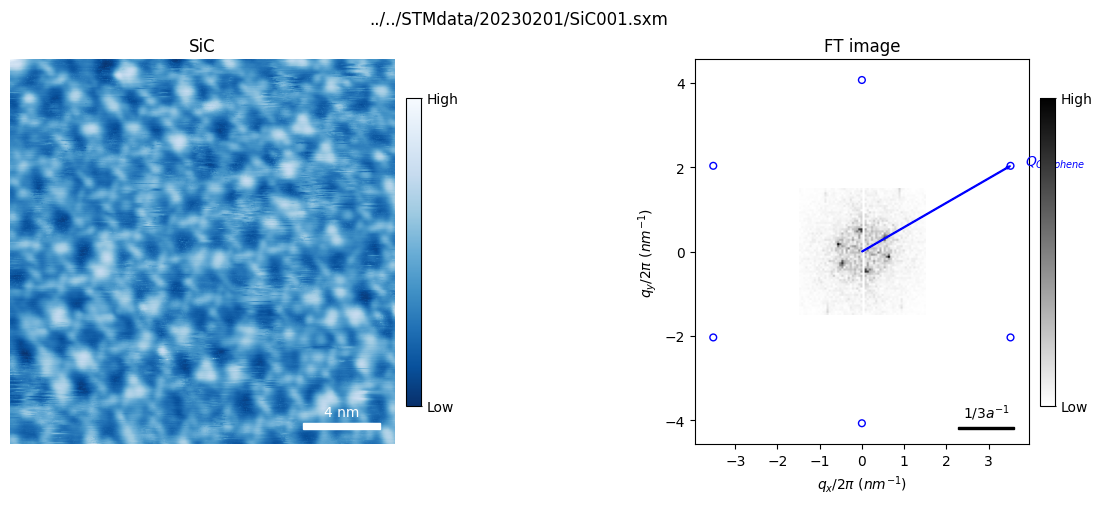

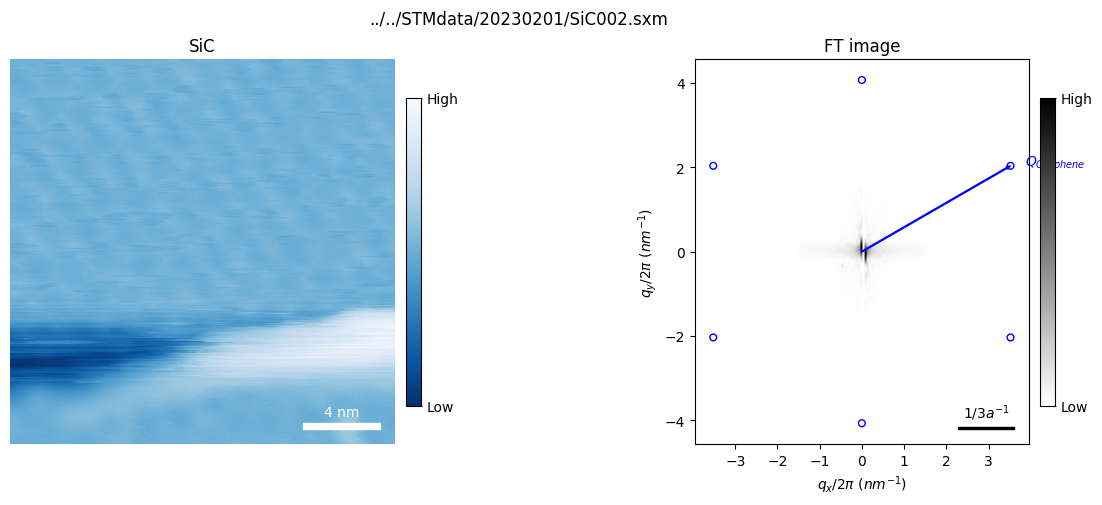

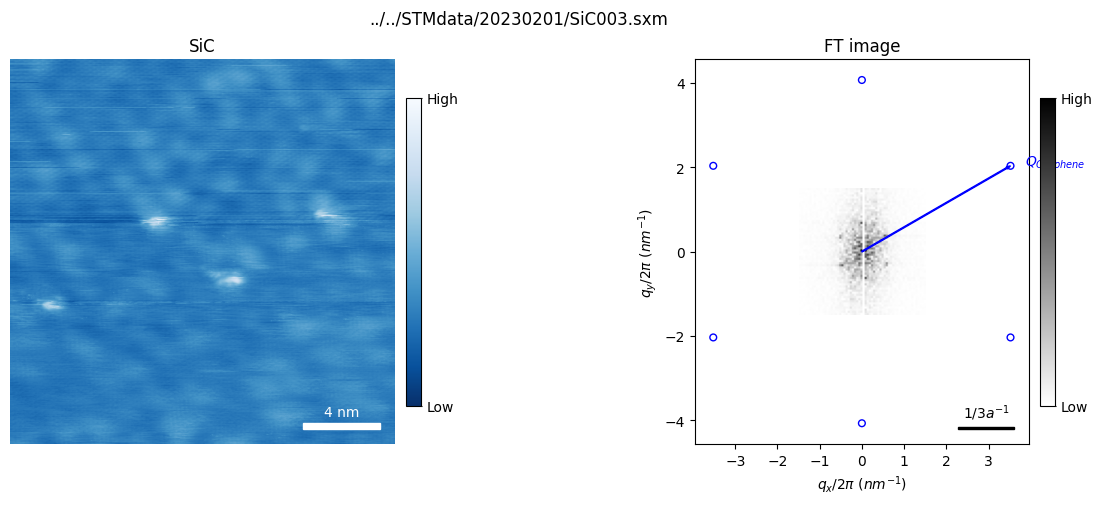

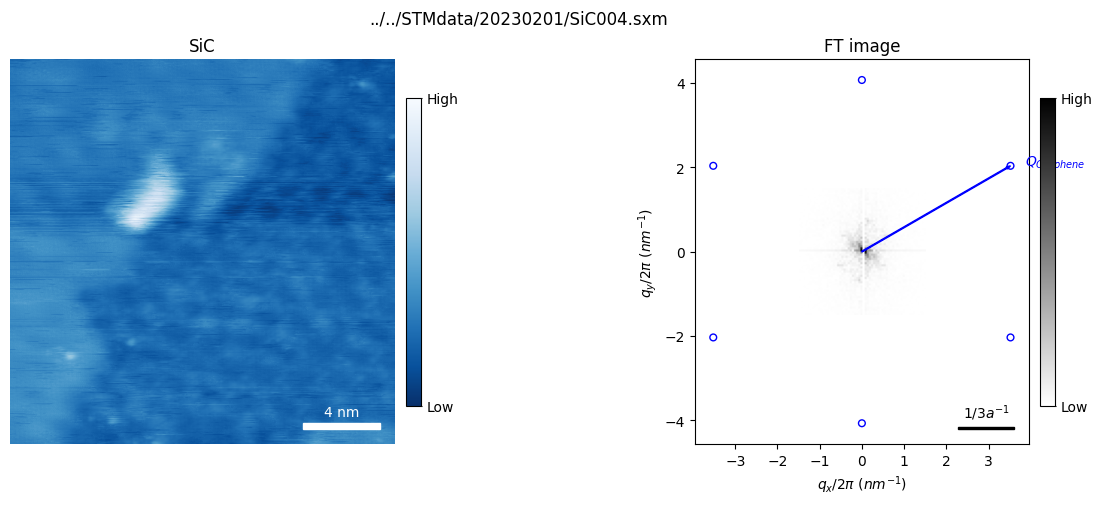

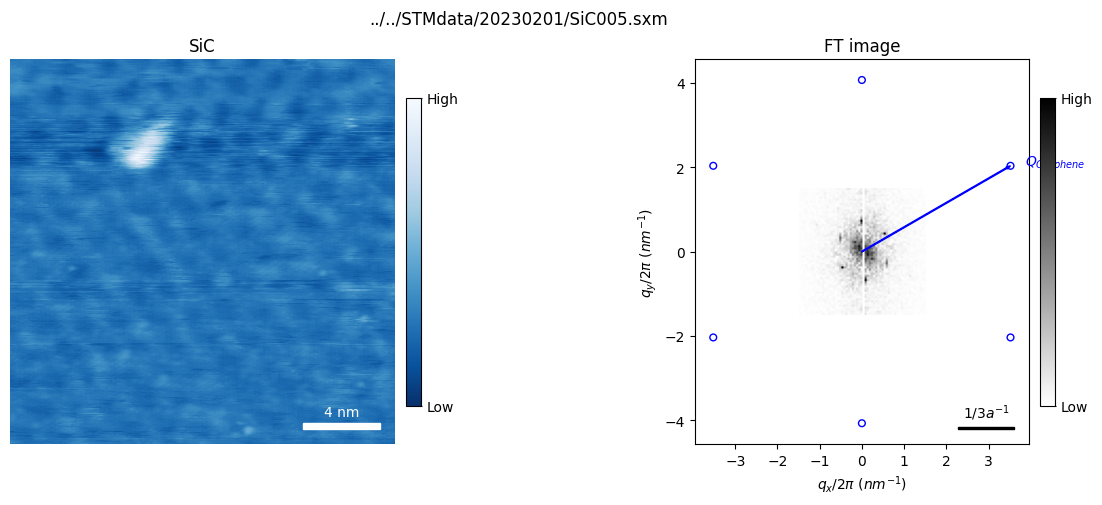

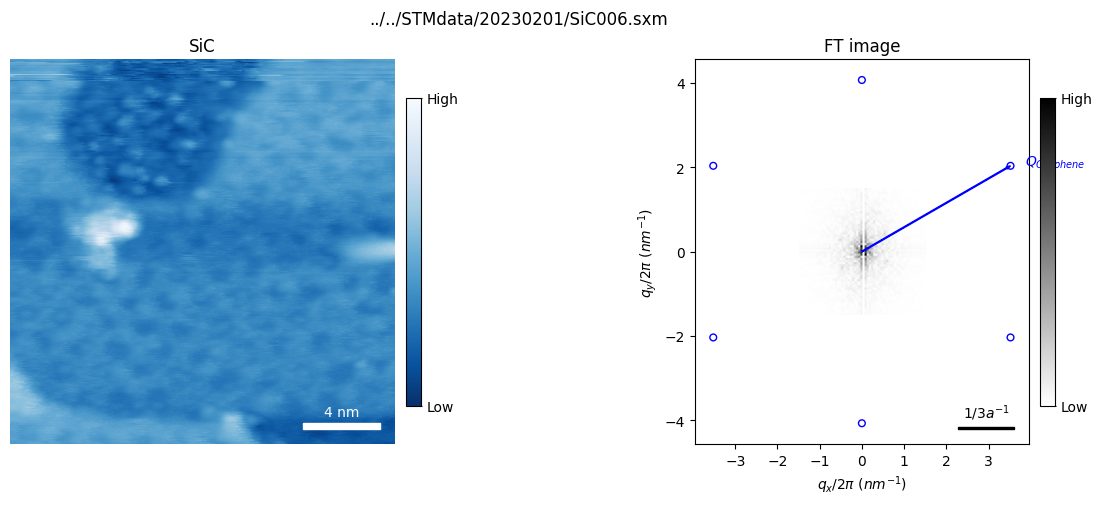

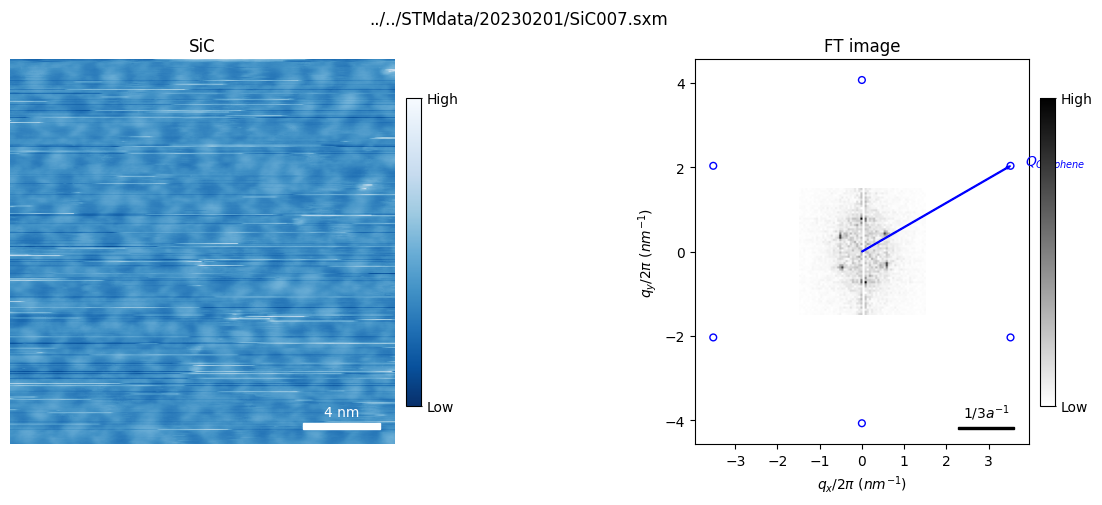

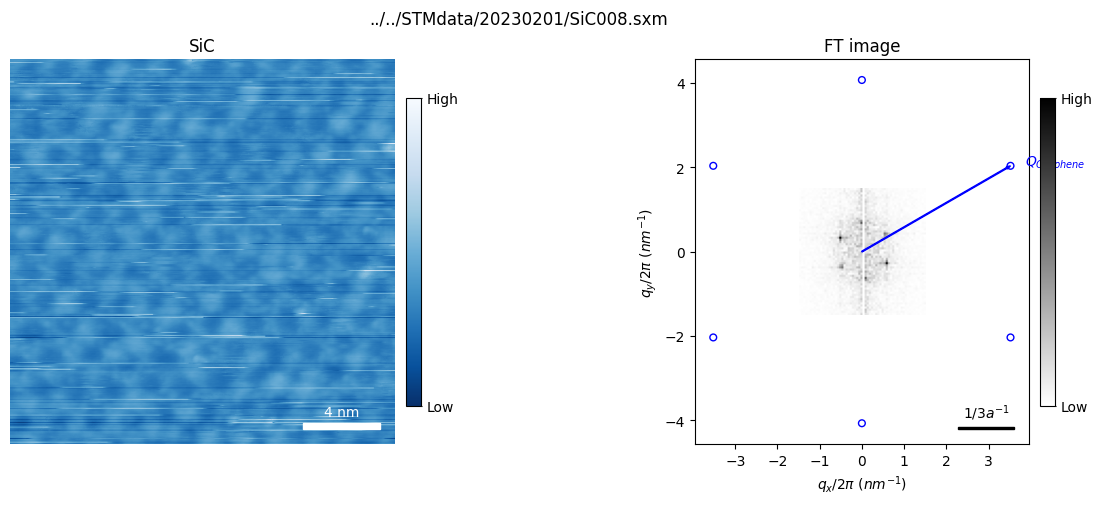

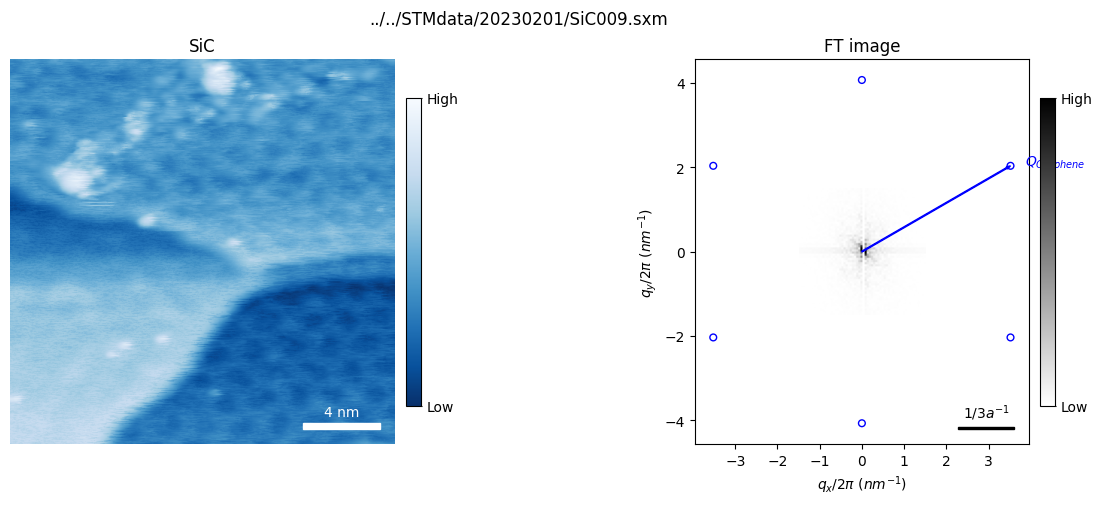

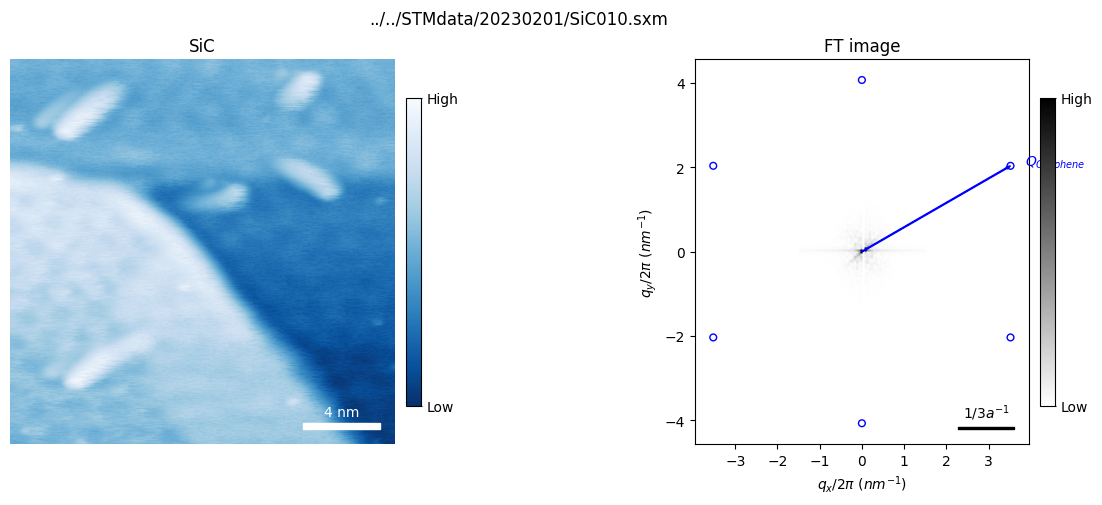

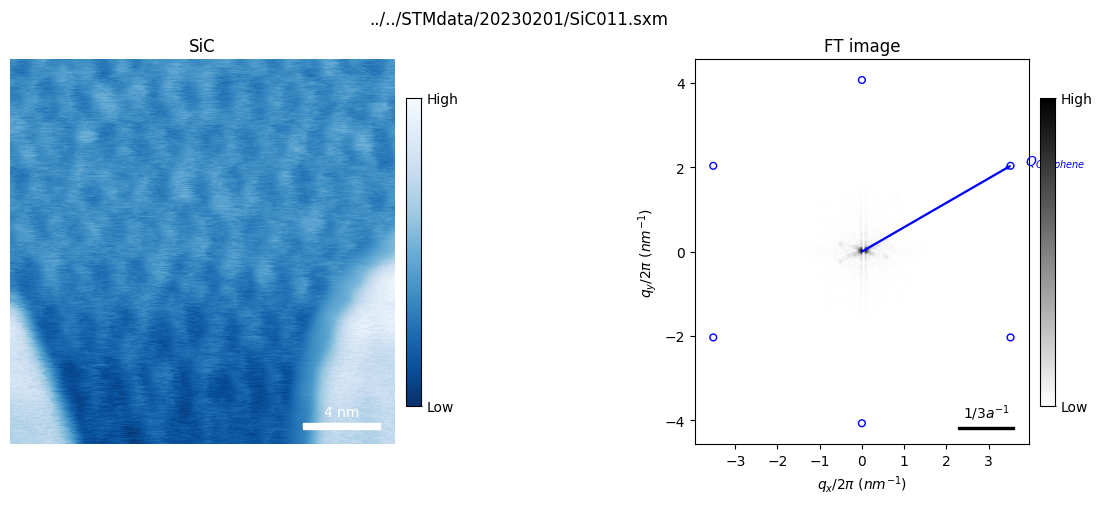

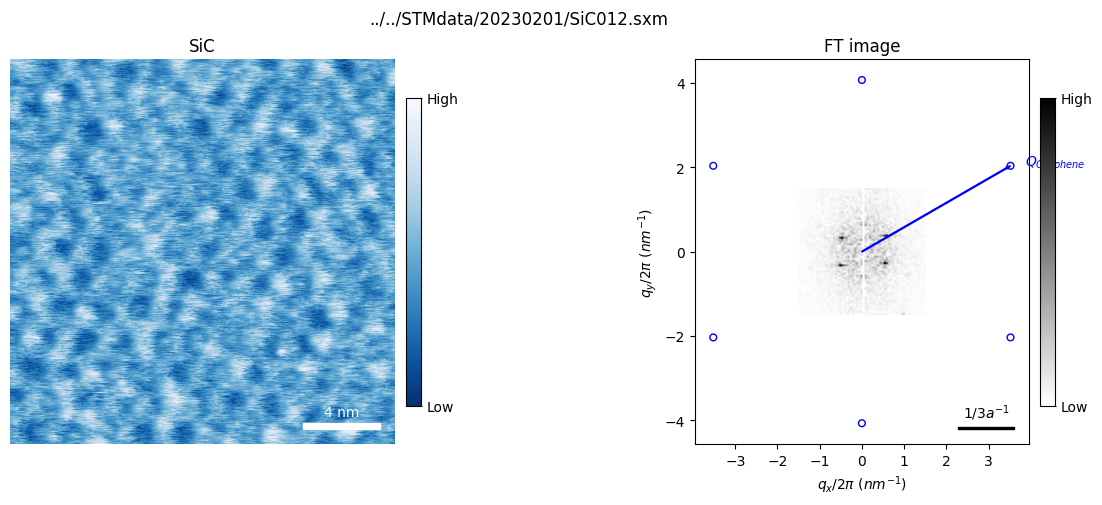

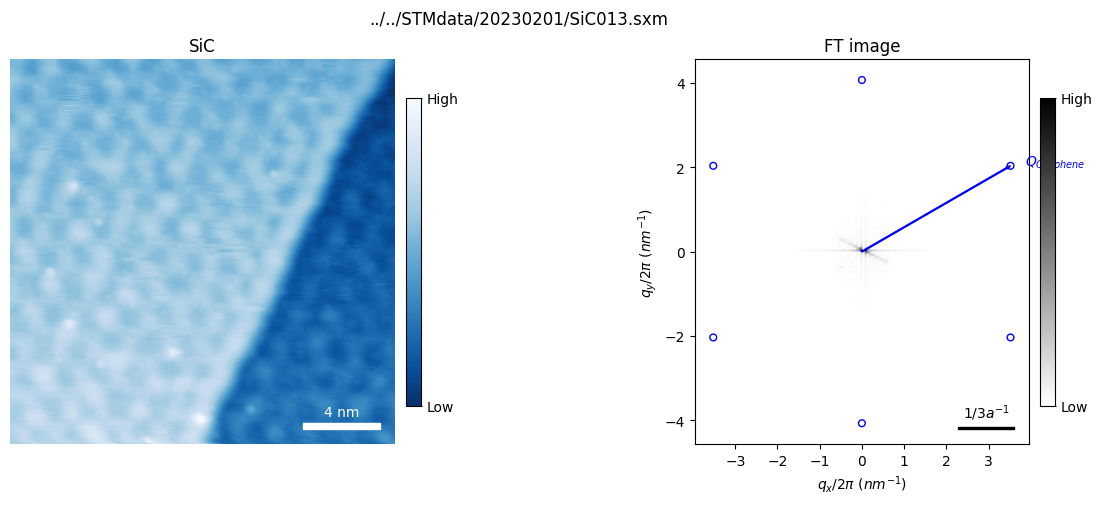

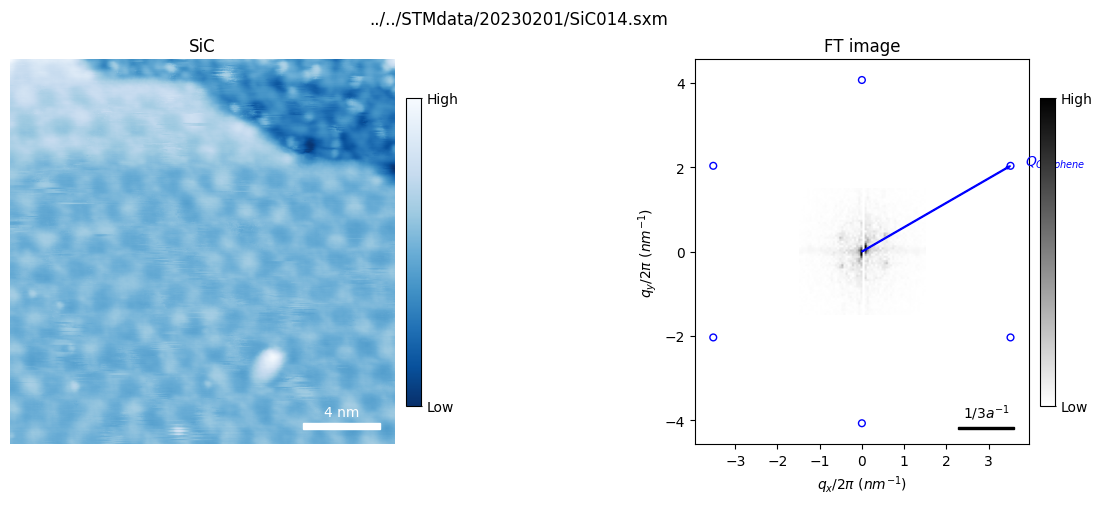

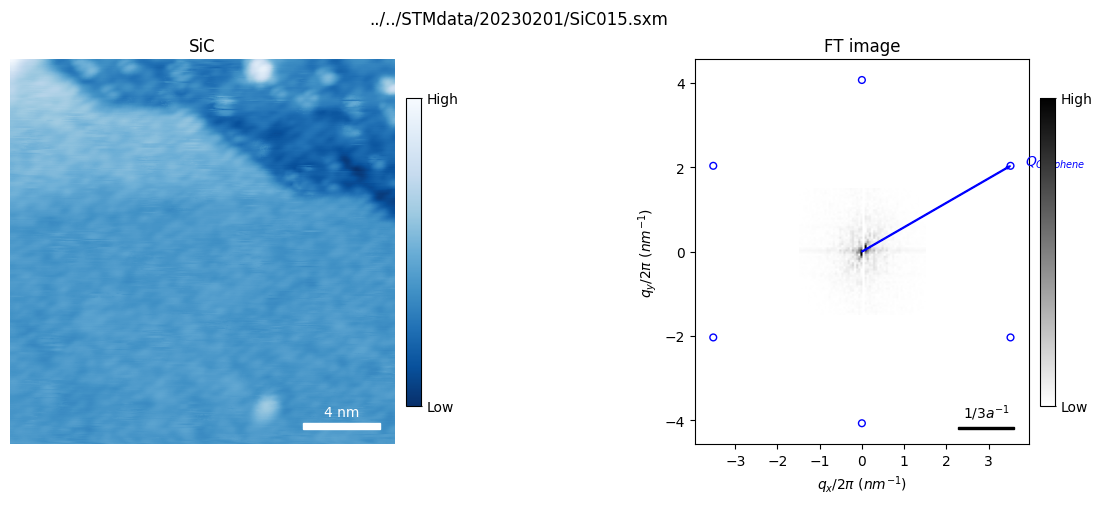

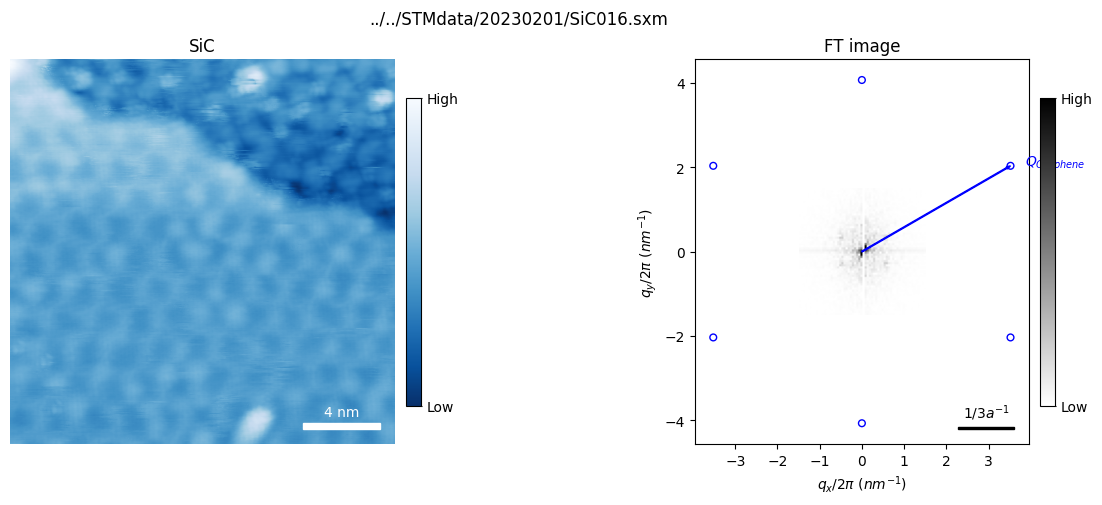

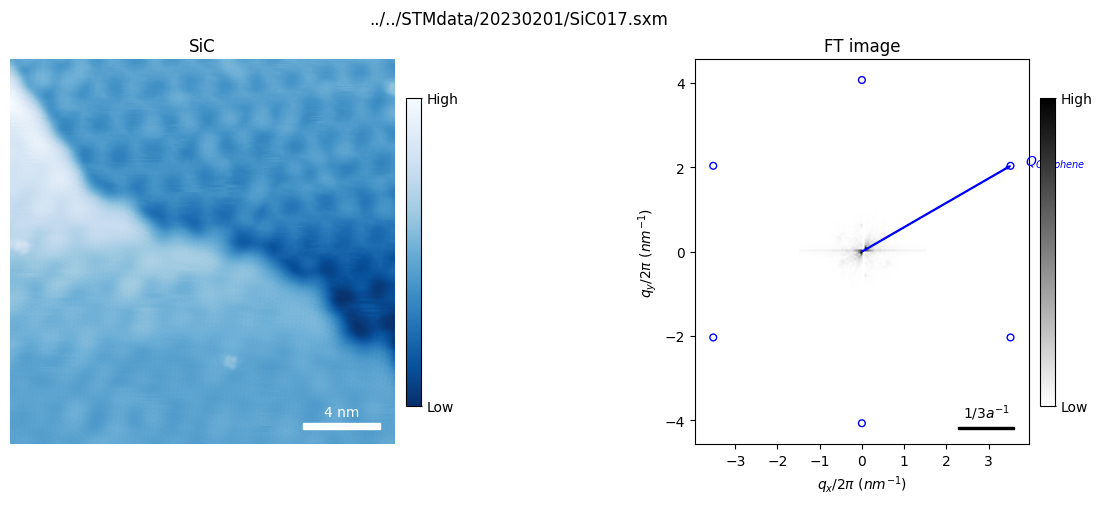

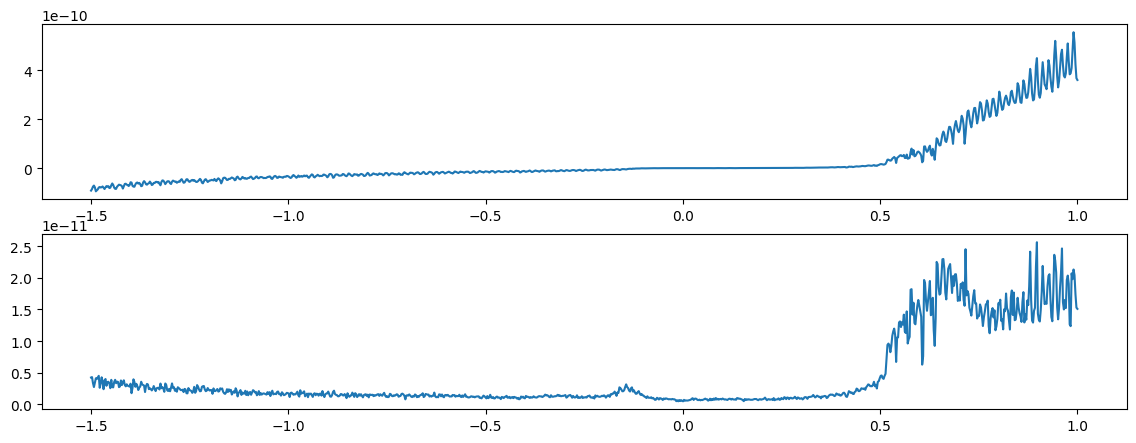

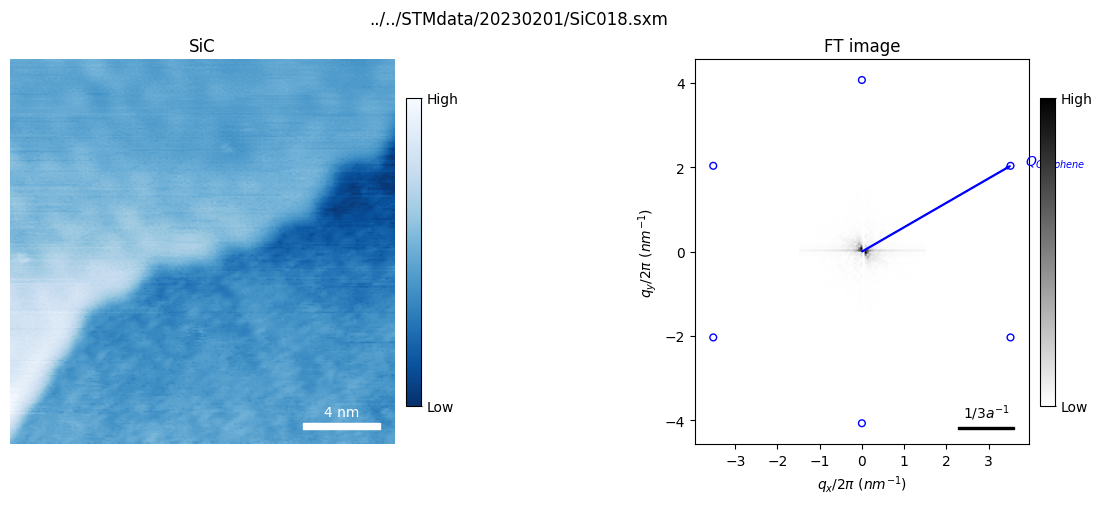

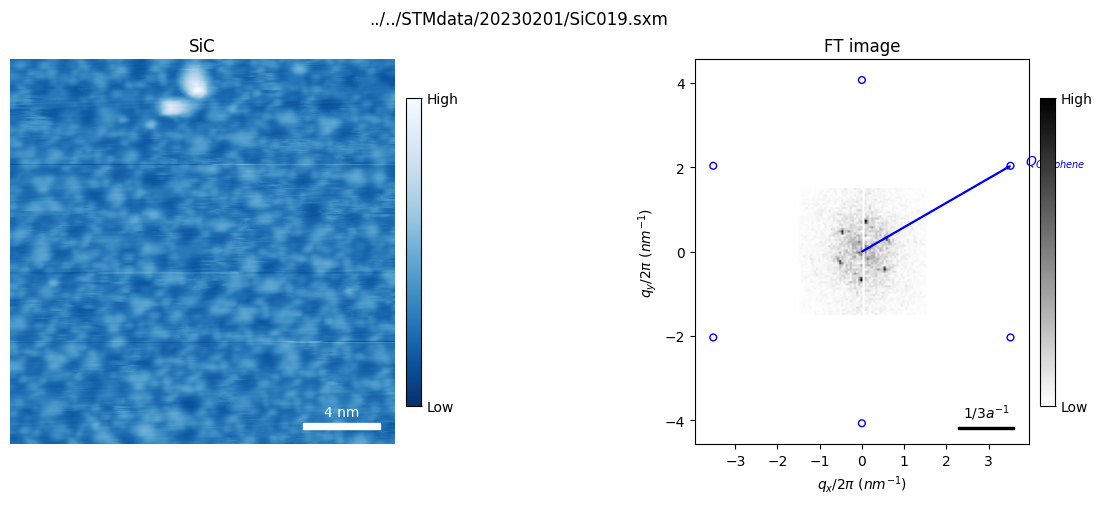

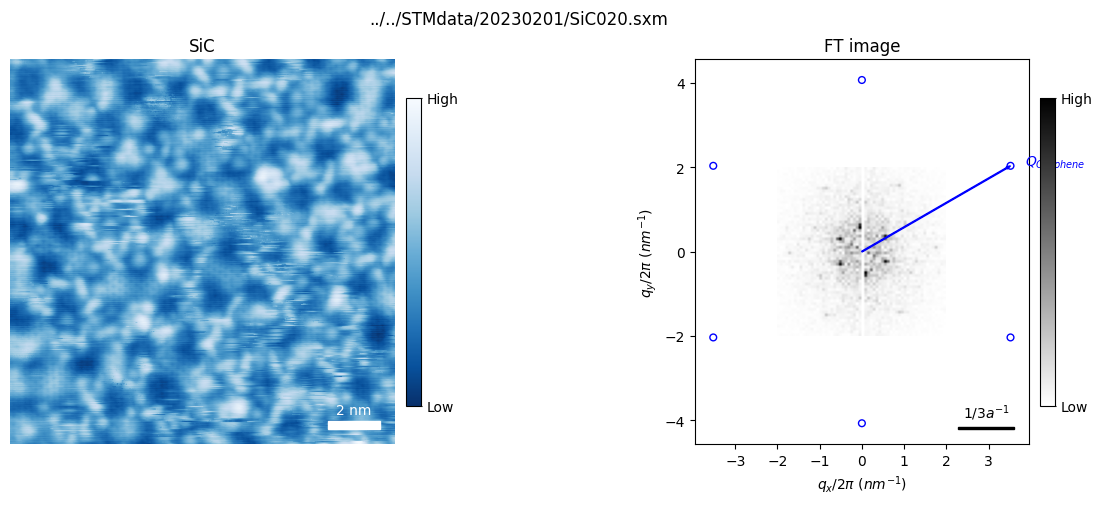

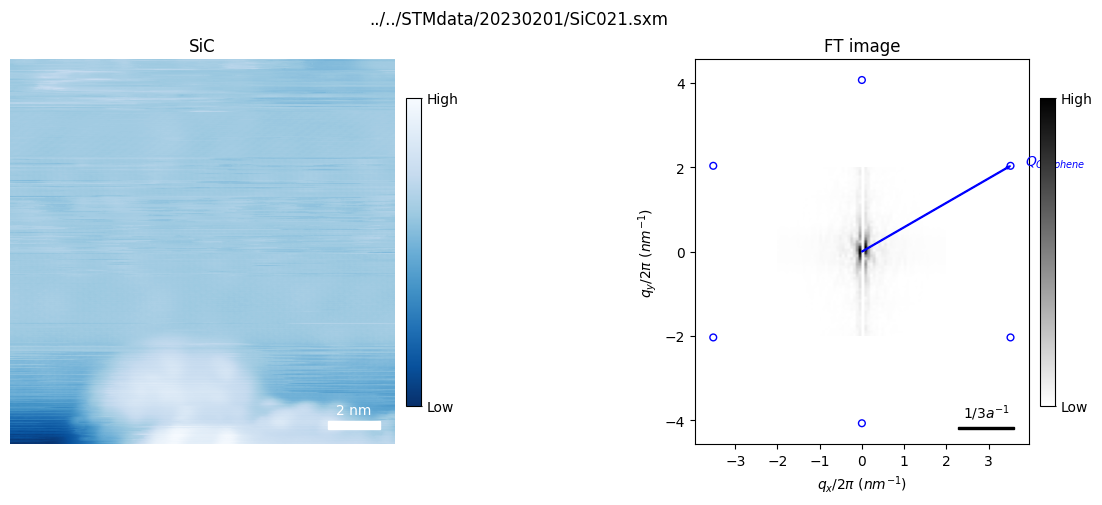

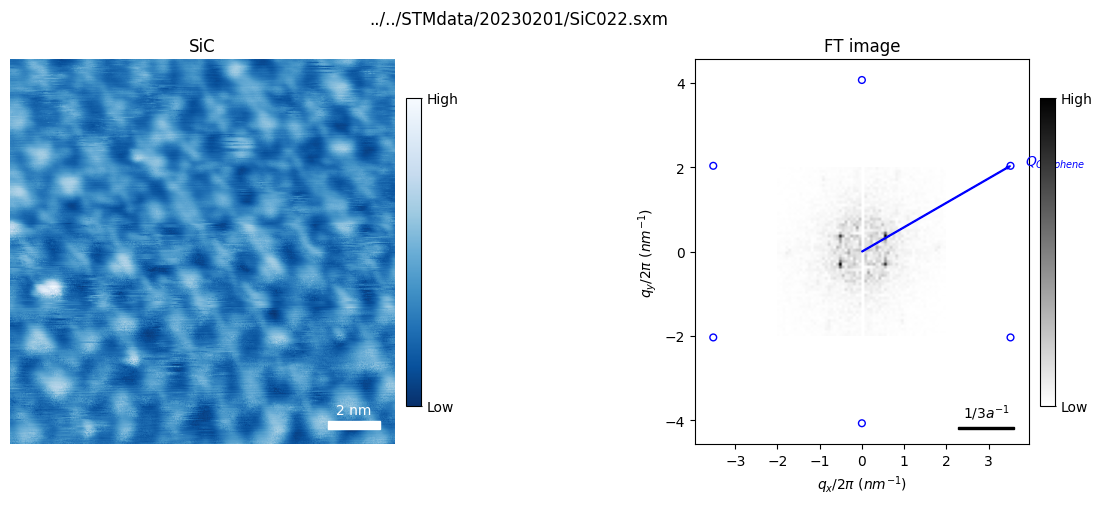

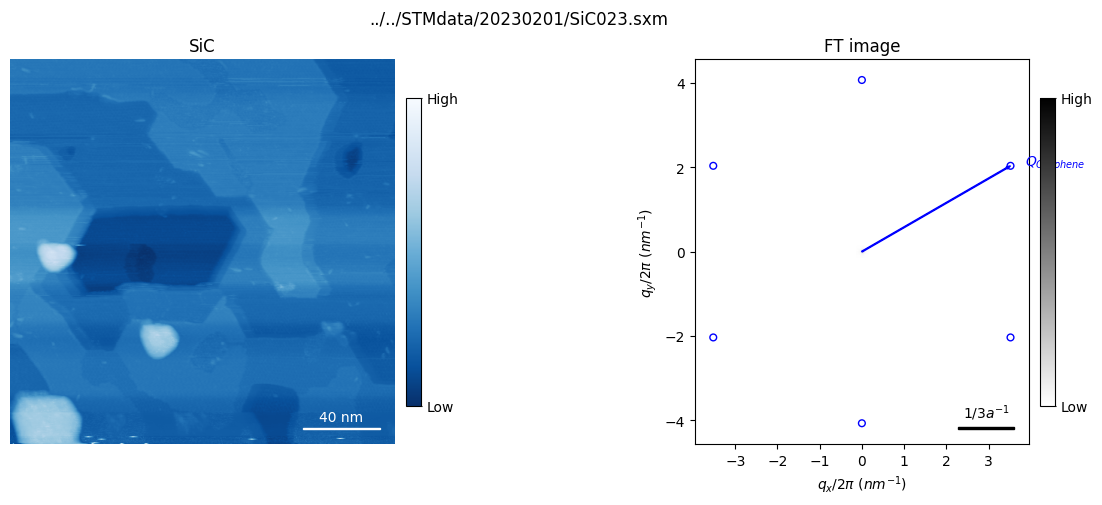

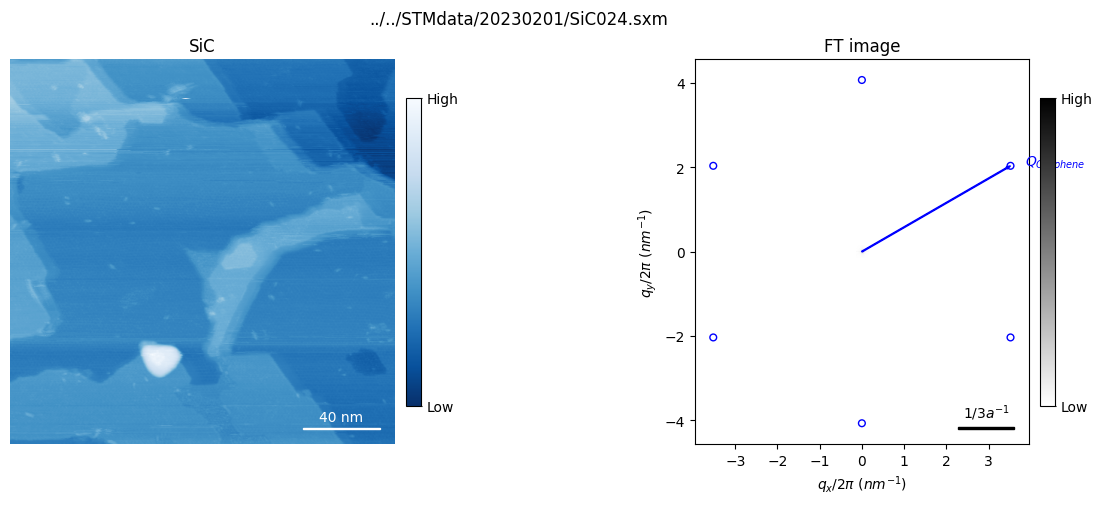

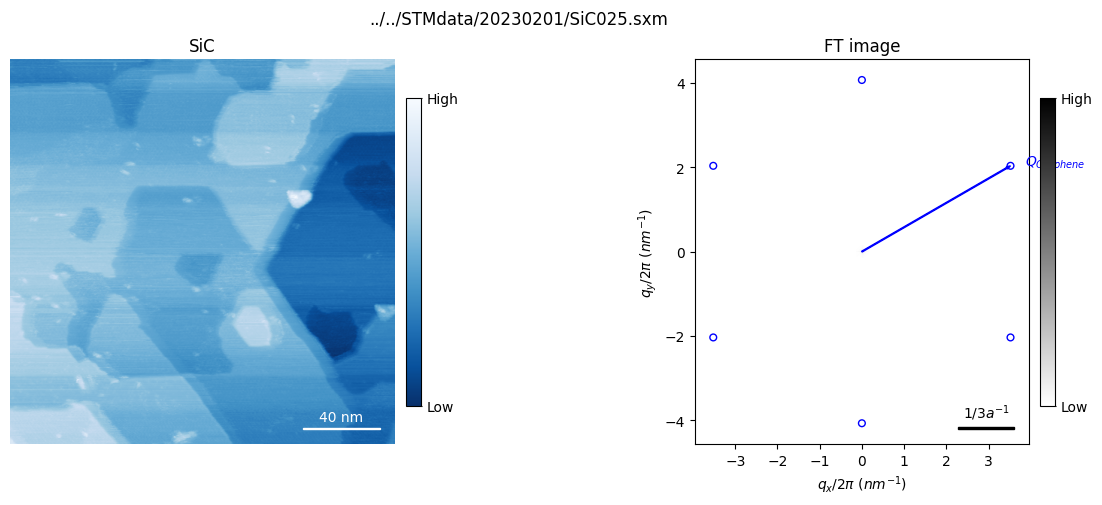

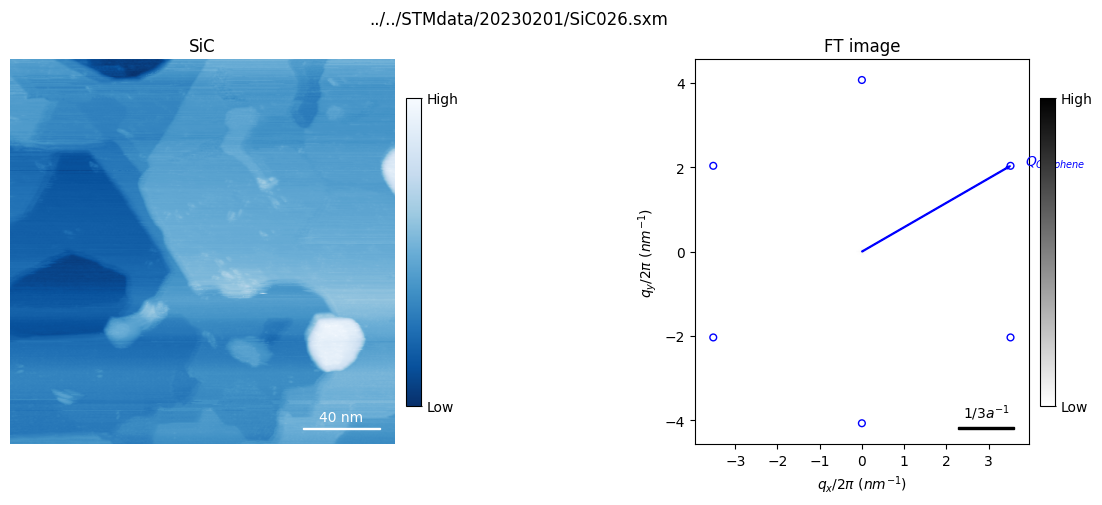

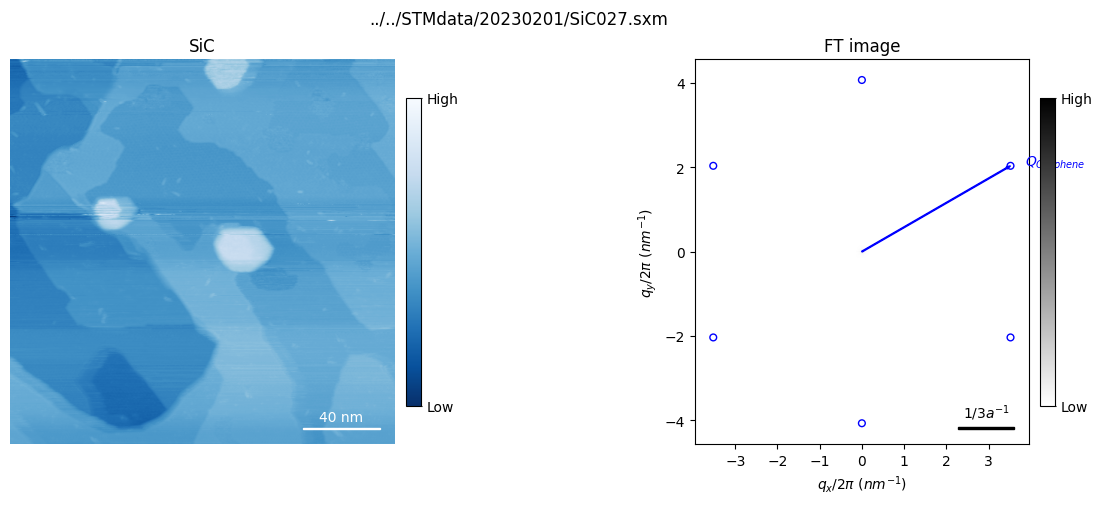

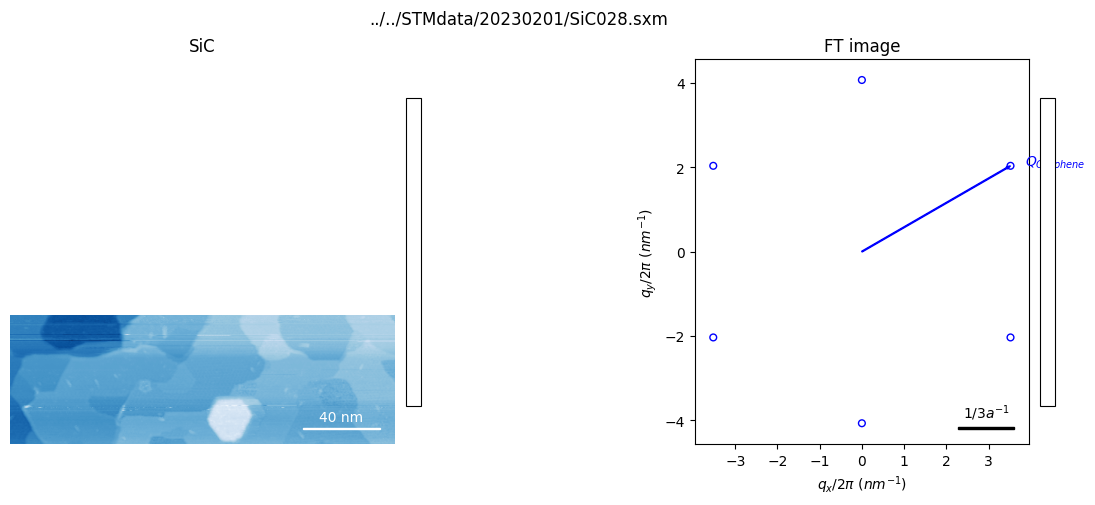

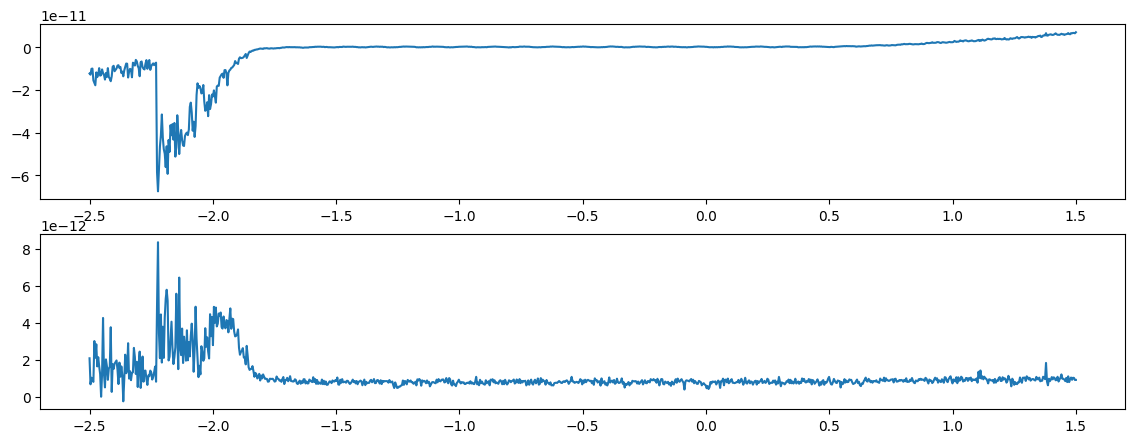

In [77]:
mydir,myFolder,fileName="../../STMdata","20230201","SiC006.sxm"
mypath=join(mydir,myFolder)
files=[f for f in os.listdir(mypath) if isfile(join(mypath,f))]
filePaths=[join(mypath,file) for file in files]
filePaths.sort(key=os.path.getmtime)
print(filePaths)
for filePath in filePaths: 
    if filePath.endswith(".sxm"):
        plot_image(filePath)
        pass
    elif filePath.endswith(".dat"):
        plot_STS(filePath)


